### Лабораторная работа №6

По имеющемуся образцу создайте разреженное представление функции f(t) = cos(10wt + 30) + 2cos(750wt) + sin(150wt). 
Здесь w - "омега" = 2*pi Какое количество отсчетов потребовалось для решения задачи?


In [26]:
import numpy as np
import matplotlib.pyplot as plt
# import os
# import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams.update({'font.size': 18})

In [52]:
# Функцию cosamp можно загрузить с сайта https://github.com/avirmaux/CoSaMP

def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u, rcond=None)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

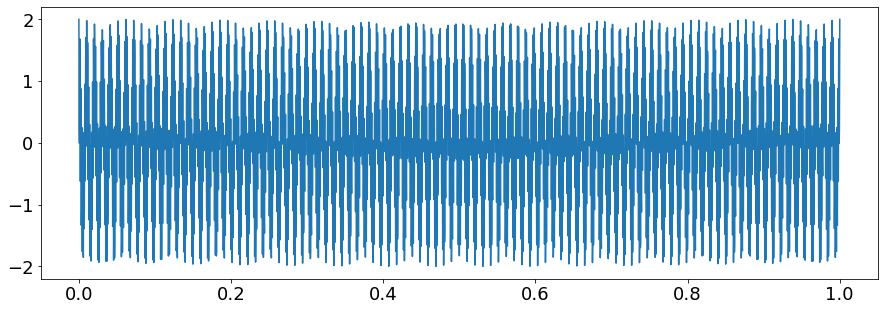

In [27]:
## Генерация сигнала, выполнение Фурье преобразования

n = 4096 # точки отсчетов для высокого разрешения
t = np.linspace(0,1,n)
w = 2*np.pi
# x = np.cos(10*w*t + 30) + 2*np.cos(750*w*t) + np.sin(150*w*t)
x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t) # задание функции в виде суммы двух косинусоид
xt = np.fft.fft(x) # Получение Фурье-образа функции
PSD = xt * np.conj(xt) / n # Расчет спектральной плотности мощности
plt.plot(t,x)

In [56]:
## Взятие 128 рандомных отсчетов из сигнала
p = 128 # число случайных (сжатых) измерений, p = n/32
perm = np.floor(np.random.rand(p) * n).astype(int) # формирование массива индексов для случайной выборки 128 отсчетов
y = x[perm] # массив значений функции из выбранных случайным образом 128 отсчетов - "сжатое измерение"

#  print(perm[perm.argsort()])
## Восстановление сигнала из ограниченного числа отсчетов
Psi = dct(np.identity(n)) # создание матрицы "Пси"
Theta = Psi[perm,:]       # Значения функции для соответствующих строк матрицы "Пси"

s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=8) # Получение разреженного вектора s через CoSaMP
# xrecon = idct(s) # Реконструкция сигнала на основе 128 случайных выборок
print(s[0])

0.0


In [54]:
print(s)

[0. 0. 0. ... 0. 0. 0.]
